In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import cuml
import torch
from anndata import AnnData
import seaborn as sns
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from scipy.stats import spearmanr
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import squidpy as sq
from matplotlib.colors import ListedColormap

In [56]:
from pipeline import LoadCytAssistPipeline, LoadVisiumPipeline
from pipeline import IntegrateDatasetPipeline, TrainModelPipeline, InferencePipeline
from pipeline import column_corr
from plotting import plot_latent

In [82]:
hex_colors =  ["#4a3e38",
"#9fbfa2",
"#b99bbd",
"#53366c",
"#b2834b",
"#00612e",
"#00acef",
"#00eee9",
"#ba4850",
"#cac84d",
"#ce52ad",
"#76d05c",
"#794bc8",
"#e85a00"]

colors = ListedColormap(sns.color_palette(hex_colors))
# colors

### Load annotation files

In [4]:
antibody_panel = pd.read_csv('../antibody_panel.csv')
adata_annot = sc.read_h5ad("../adata/tonsil_cytassist.h5ad")
data_path = '../data/TonsilTissue'

### Initialize dataloader pipelines

In [5]:
train_loader = LoadCytAssistPipeline(
    tissue='Tonsil', 
    h5_file=data_path+'/GEX_PEX/filtered_feature_bc_matrix.h5',
    geneset=f'../data/Tonsil.txt',
    sample_id = 0,
    name = 'Tonsil 1',
    celltypes = adata_annot.obs.celltype
)

eval_loader = LoadCytAssistPipeline(
    tissue='Tonsil', 
    h5_file=data_path+'/GEX_PEX_2/filtered_feature_bc_matrix.h5',
    geneset=f'../data/Tonsil.txt',
    sample_id = 1,
    name = 'Tonsil 2',
    celltypes = adata_annot.obs.celltype
)

test_loader = LoadVisiumPipeline(
    tissue='Tonsil', 
    visium_dir=data_path+'/GEX', 
    sample_id=2, 
    name='ST Only'
)

Created CytAssist data loader pipeline.
Created CytAssist data loader pipeline.
Created 10x Visium data loader pipeline.


### Load training and evaluation data

In [6]:
adata, pdata = train_loader.run() ## fresh copy of training data
adata_eval, pdata_eval = eval_loader.run() ## fresh copy of eval data
adata, adata_eval = IntegrateDatasetPipeline('Tonsil', adata, adata_eval).run() ## integrate

Created data integration pipeline.


### Train SPICESS model

In [7]:
trainer = TrainModelPipeline(
    tissue = 'Tonsil',
    adata = adata,
    pdata = pdata,
    adata_eval = adata_eval,
    pdata_eval = pdata_eval,
    latent_dim = 50,
    save = True
)

Created training pipeline.


In [8]:
spicess = trainer.run()

Imputation: 0.710 || Alignment: 0.504% | Loss: 0.011 | lr: 1.0e-03: 100%|██████████| 10000/10000 [19:30<00:00,  8.54it/s, es-counter=190] 


Saved model-config to ../model_zoo/config_Tonsil_2023_10_03_17_35.yaml


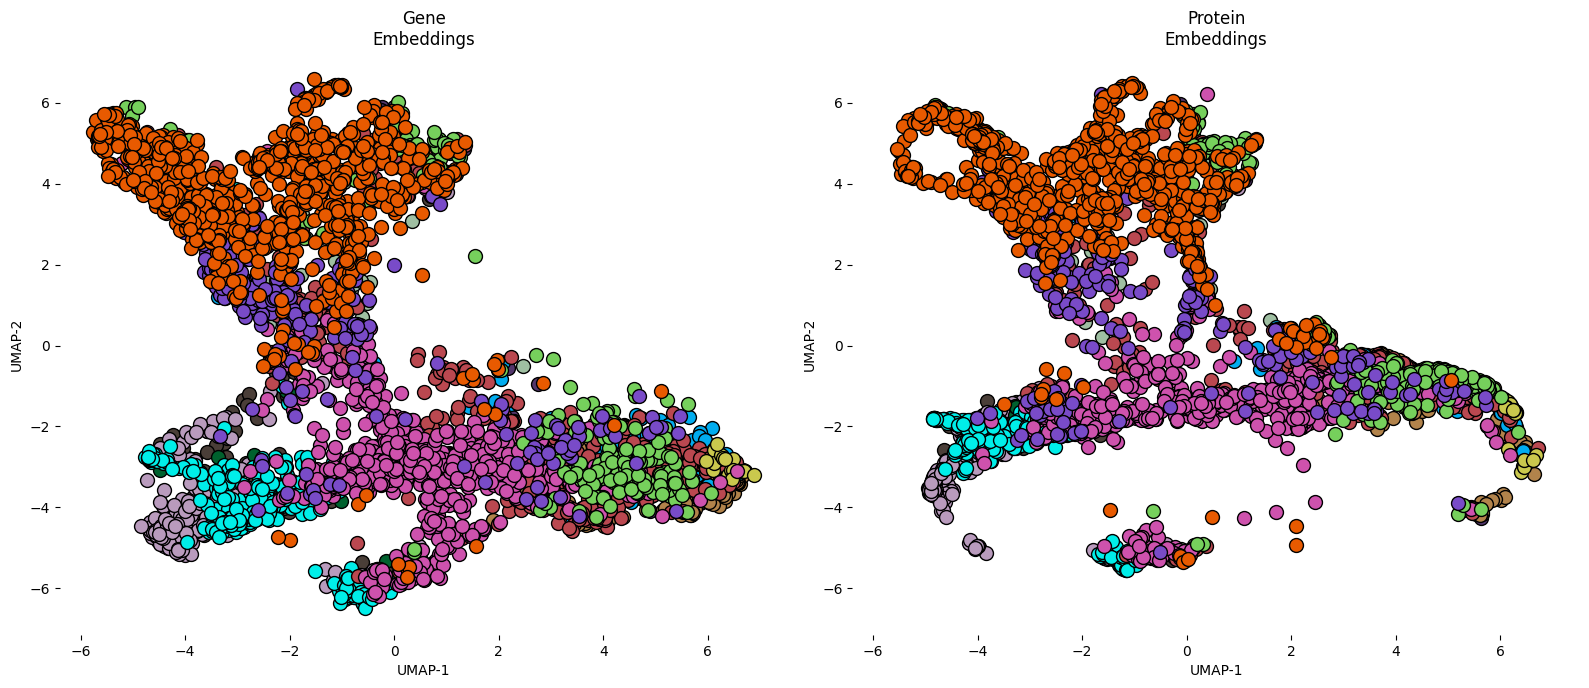

In [9]:
integrated_data =  spicess.model(X=[spicess.d11, spicess.d12], A=spicess.A)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()
refLabels = adata.obs.celltypes.values #cell2location labels
a, b = plot_latent([gex_z, pex_z], [refLabels, refLabels])

### Inference Pipeline

Load pre-trained model from config file.

In [10]:
infer = InferencePipeline('../model_zoo/config_Tonsil_2023_10_02_22_19.yaml')

Created inference pipeline.


In [59]:
pdata_pred = infer.run(adata_eval) 

In [63]:
## predicted protein expression
pdata_pred.to_df()

CD163       CR2      PCNA       VIM      KRT5  \
AACACGTGCATCGCAC-1-1-1  0.586369  0.606358  0.495755  0.854187  0.097988   
AACACTTGGCAAGGAA-1-1-1  0.791126  0.777508  0.440937  0.721947  0.086208   
AACAGGAAGAGCATAG-1-1-1  0.704577  0.781729  0.738696  0.752714  0.135078   
AACAGGATTCATAGTT-1-1-1  0.767602  0.944176  0.374810  0.775345  0.164589   
AACAGGCCAACGATTA-1-1-1  0.780034  0.807171  0.528466  0.608143  0.113352   
...                          ...       ...       ...       ...       ...   
TGTTGGAACGAGGTCA-1-1-1  0.678155  0.687303  0.406129  0.673884  0.058072   
TGTTGGAAGCTCGGTA-1-1-1  0.569443  0.502810  0.377017  0.815895  0.057358   
TGTTGGATGGACTTCT-1-1-1  0.722662  0.762106  0.531684  0.763157  0.399027   
TGTTGGCCAGACCTAC-1-1-1  0.763392  0.990143  0.386410  0.947516  0.133765   
TGTTGGCCTACACGTG-1-1-1  0.635915  0.594919  0.428058  0.851283  0.068744   

                            CD68   CEACAM8   PTPRC_1      PAX5      SDC1  ...  \
AACACGTGCATCGCAC-1-1-1  0.609574  0.056524  0.807943  0.330891  0.239993  ...   
AACACTTGGCAAGGAA-1-1-1  0.371945  0.033603  0.812850  0.657817  0.489905  ...   
AACAGGAAGAGCATAG-1-1-1  0.637182  0.031691  0.848681  0.725975  0.476995  ...   
AACAGGATTCATAGTT-1-1-1  0.067546  0.199757  0.598617  0.462098  0.498324  ...   
AACAGGCCAACGATTA-1-1-1  0.398463  0.036319  0.682151  0.758780  0.654155  ...   
...                          ...       ...       ...       ...       ...  ...   
TGTTGGAACGAGGTCA-1-1-1  0.402498  0.020356  0.679764  0.444826  0.489638  ...   
TGTTGGAAGCTCGGTA-1-1-1  0.406172  0.033331  0.591649  0.225105  0.420161  ...   
TGTTGGATGGACTTCT-1-1-1  0.538608  0.078421  0.885152  0.581743  0.367035  ...   
TGTTGGCCAGACCTAC-1-1-1  0.056410  0.238767  0.597299  0.419863  0.437412  ...   
TGTTGGCCTACACGTG-1-1-1  0.540951  0.036614  0.759850  0.313467  0.288572  ...   

                           MS4A1      CD3E      CD14      CD40    PECAM1  \
AACACGTGCATCGCAC-1-1-1  0.555346  0.872079  0.678468  0.726227  0.665117   
AACACTTGGCAAGGAA-1-1-1  0.568023  0.696922  0.745132  0.688154  0.362540   
AACAGGAAGAGCATAG-1-1-1  0.775658  0.669519  0.686853  0.753875  0.249469   
AACAGGATTCATAGTT-1-1-1  0.421170  0.558087  0.946499  0.693704  0.597014   
AACAGGCCAACGATTA-1-1-1  0.552522  0.624540  0.759193  0.676100  0.258832   
...                          ...       ...       ...       ...       ...   
TGTTGGAACGAGGTCA-1-1-1  0.462813  0.824907  0.707868  0.593337  0.352677   
TGTTGGAAGCTCGGTA-1-1-1  0.245148  0.909125  0.578922  0.469747  0.370139   
TGTTGGATGGACTTCT-1-1-1  0.669336  0.625515  0.744918  0.851837  0.380467   
TGTTGGCCAGACCTAC-1-1-1  0.408544  0.548823  0.975558  0.767011  0.672019   
TGTTGGCCTACACGTG-1-1-1  0.453828  0.872664  0.657888  0.640503  0.560316   

                             CD4     ITGAM      CD27      CCR7     CD274  
AACACGTGCATCGCAC-1-1-1  0.956653  0.091712  0.904653  0.731353  0.454238  
AACACTTGGCAAGGAA-1-1-1  0.985163  0.201518  0.848367  0.713787  0.241191  
AACAGGAAGAGCATAG-1-1-1  0.984386  0.372541  0.852844  0.657023  0.406809  
AACAGGATTCATAGTT-1-1-1  0.961060  0.171384  0.798859  0.699666  0.072667  
AACAGGCCAACGATTA-1-1-1  0.986264  0.319799  0.799999  0.693842  0.276653  
...                          ...       ...       ...       ...       ...  
TGTTGGAACGAGGTCA-1-1-1  0.962598  0.095117  0.870381  0.753979  0.324454  
TGTTGGAAGCTCGGTA-1-1-1  0.886592  0.060692  0.864023  0.882344  0.480680  
TGTTGGATGGACTTCT-1-1-1  0.992018  0.140862  0.861183  0.680170  0.466695  
TGTTGGCCAGACCTAC-1-1-1  0.949781  0.159468  0.807347  0.689828  0.040261  
TGTTGGCCTACACGTG-1-1-1  0.939718  0.089824  0.898945  0.785034  0.440422  

[4908 rows x 30 columns]

In [79]:
## observed protein expression
pdata_obs = AnnData(spicess.d14.detach().cpu().numpy(), var=pdata_eval.var, obs=pdata_eval.obs)
pdata_obs.to_df()

CD163       CR2      PCNA       VIM      KRT5  \
AACACGTGCATCGCAC-1  0.648430  0.827366  0.570423  0.712950  0.205452   
AACACTTGGCAAGGAA-1  0.685500  0.817678  0.441935  0.678307  0.078959   
AACAGGAAGAGCATAG-1  0.634024  0.893816  0.678973  0.759672  0.024804   
AACAGGATTCATAGTT-1  0.702376  0.869961  0.514980  0.857683  0.028142   
AACAGGCCAACGATTA-1  0.756211  0.785377  0.656496  0.478364  0.084957   
...                      ...       ...       ...       ...       ...   
TGTTGGAACGAGGTCA-1  0.611487  0.710532  0.499824  0.633321  0.020311   
TGTTGGAAGCTCGGTA-1  0.630434  0.736793  0.518817  0.662685  0.009334   
TGTTGGATGGACTTCT-1  0.613947  0.823903  0.620811  0.671655  0.506761   
TGTTGGCCAGACCTAC-1  0.670337  0.828496  0.464444  0.729277  0.027301   
TGTTGGCCTACACGTG-1  0.662779  0.700068  0.374358  0.656283  0.049744   

                        CD68   CEACAM8   PTPRC_1      PAX5      SDC1  ...  \
AACACGTGCATCGCAC-1  0.566910  0.088359  0.724579  0.181567  0.146393  ...   
AACACTTGGCAAGGAA-1  0.555391  0.041369  0.798806  0.180606  0.136997  ...   
AACAGGAAGAGCATAG-1  0.554527  0.104343  0.768270  0.234092  0.138022  ...   
AACAGGATTCATAGTT-1  0.489930  0.000000  0.689573  0.028142  0.203333  ...   
AACAGGCCAACGATTA-1  0.678050  0.055562  0.655592  0.297930  0.114858  ...   
...                      ...       ...       ...       ...       ...  ...   
TGTTGGAACGAGGTCA-1  0.626899  0.055321  0.679083  0.047467  0.121110  ...   
TGTTGGAAGCTCGGTA-1  0.532783  0.071518  0.736530  0.076745  0.155424  ...   
TGTTGGATGGACTTCT-1  0.617408  0.071917  0.800080  0.258663  0.212386  ...   
TGTTGGCCAGACCTAC-1  0.340967  0.027301  0.470502  0.000000  0.156986  ...   
TGTTGGCCTACACGTG-1  0.489237  0.055475  0.657316  0.066751  0.080351  ...   

                       MS4A1      CD3E      CD14      CD40    PECAM1  \
AACACGTGCATCGCAC-1  0.556861  1.000000  0.729628  0.894727  0.746333   
AACACTTGGCAAGGAA-1  0.542338  0.917784  0.732734  0.885773  0.610975   
AACAGGAAGAGCATAG-1  0.692336  0.933409  0.720534  0.886242  0.764865   
AACAGGATTCATAGTT-1  0.448172  0.807468  0.822616  0.853667  0.777729   
AACAGGCCAACGATTA-1  0.549412  0.768794  0.696297  0.847965  0.583898   
...                      ...       ...       ...       ...       ...   
TGTTGGAACGAGGTCA-1  0.418146  1.000000  0.632949  0.770114  0.671327   
TGTTGGAAGCTCGGTA-1  0.428804  1.000000  0.668851  0.760835  0.579659   
TGTTGGATGGACTTCT-1  0.606924  0.768819  0.694797  0.804841  0.489982   
TGTTGGCCAGACCTAC-1  0.368866  0.629730  0.682243  0.781071  0.571717   
TGTTGGCCTACACGTG-1  0.296327  1.000000  0.634399  0.780079  0.563483   

                         CD4     ITGAM      CD27      CCR7     CD274  
AACACGTGCATCGCAC-1  0.983108  0.247261  0.900977  0.706291  0.201245  
AACACTTGGCAAGGAA-1  1.000000  0.329646  0.883424  0.715743  0.197370  
AACAGGAAGAGCATAG-1  1.000000  0.502867  0.895620  0.751509  0.308088  
AACAGGATTCATAGTT-1  0.948862  0.258288  0.984471  0.722818  0.185186  
AACAGGCCAACGATTA-1  1.000000  0.574124  0.649644  0.742248  0.177330  
...                      ...       ...       ...       ...       ...  
TGTTGGAACGAGGTCA-1  0.967845  0.324256  0.788657  0.696361  0.208309  
TGTTGGAAGCTCGGTA-1  0.982983  0.230180  0.780062  0.774364  0.225085  
TGTTGGATGGACTTCT-1  1.000000  0.236939  0.854213  0.714563  0.304390  
TGTTGGCCAGACCTAC-1  0.741552  0.236007  0.774113  0.597495  0.118973  
TGTTGGCCTACACGTG-1  0.989547  0.294939  0.658694  0.849070  0.243258  

[4908 rows x 30 columns]

In [80]:
column_corr(pdata_pred.X, pdata_obs.X)

[0.30617464630175645,
 0.6020523044468199,
 0.5423404122979194,
 0.39258642388970544,
 0.785186969875913,
 0.3125556948946385,
 0.3363712314592672,
 0.4618070708382857,
 0.6916554286967466,
 0.21519866001230484,
 0.7460261564940744,
 0.6913241758782062,
 0.5656988889443343,
 0.6613868515776461,
 0.7116600766762448,
 0.7454535466987512,
 0.07722708281021852,
 0.5284557849869831,
 0.8381867350797312,
 0.33749752815115525,
 0.6700376927975314,
 0.8320040670725368,
 0.42741296546361324,
 0.197649057123066,
 0.6675376131094197,
 0.3829220222571869,
 0.626450958978151,
 0.26100327067760654,
 0.1524103831448712,
 0.6792045168395251]

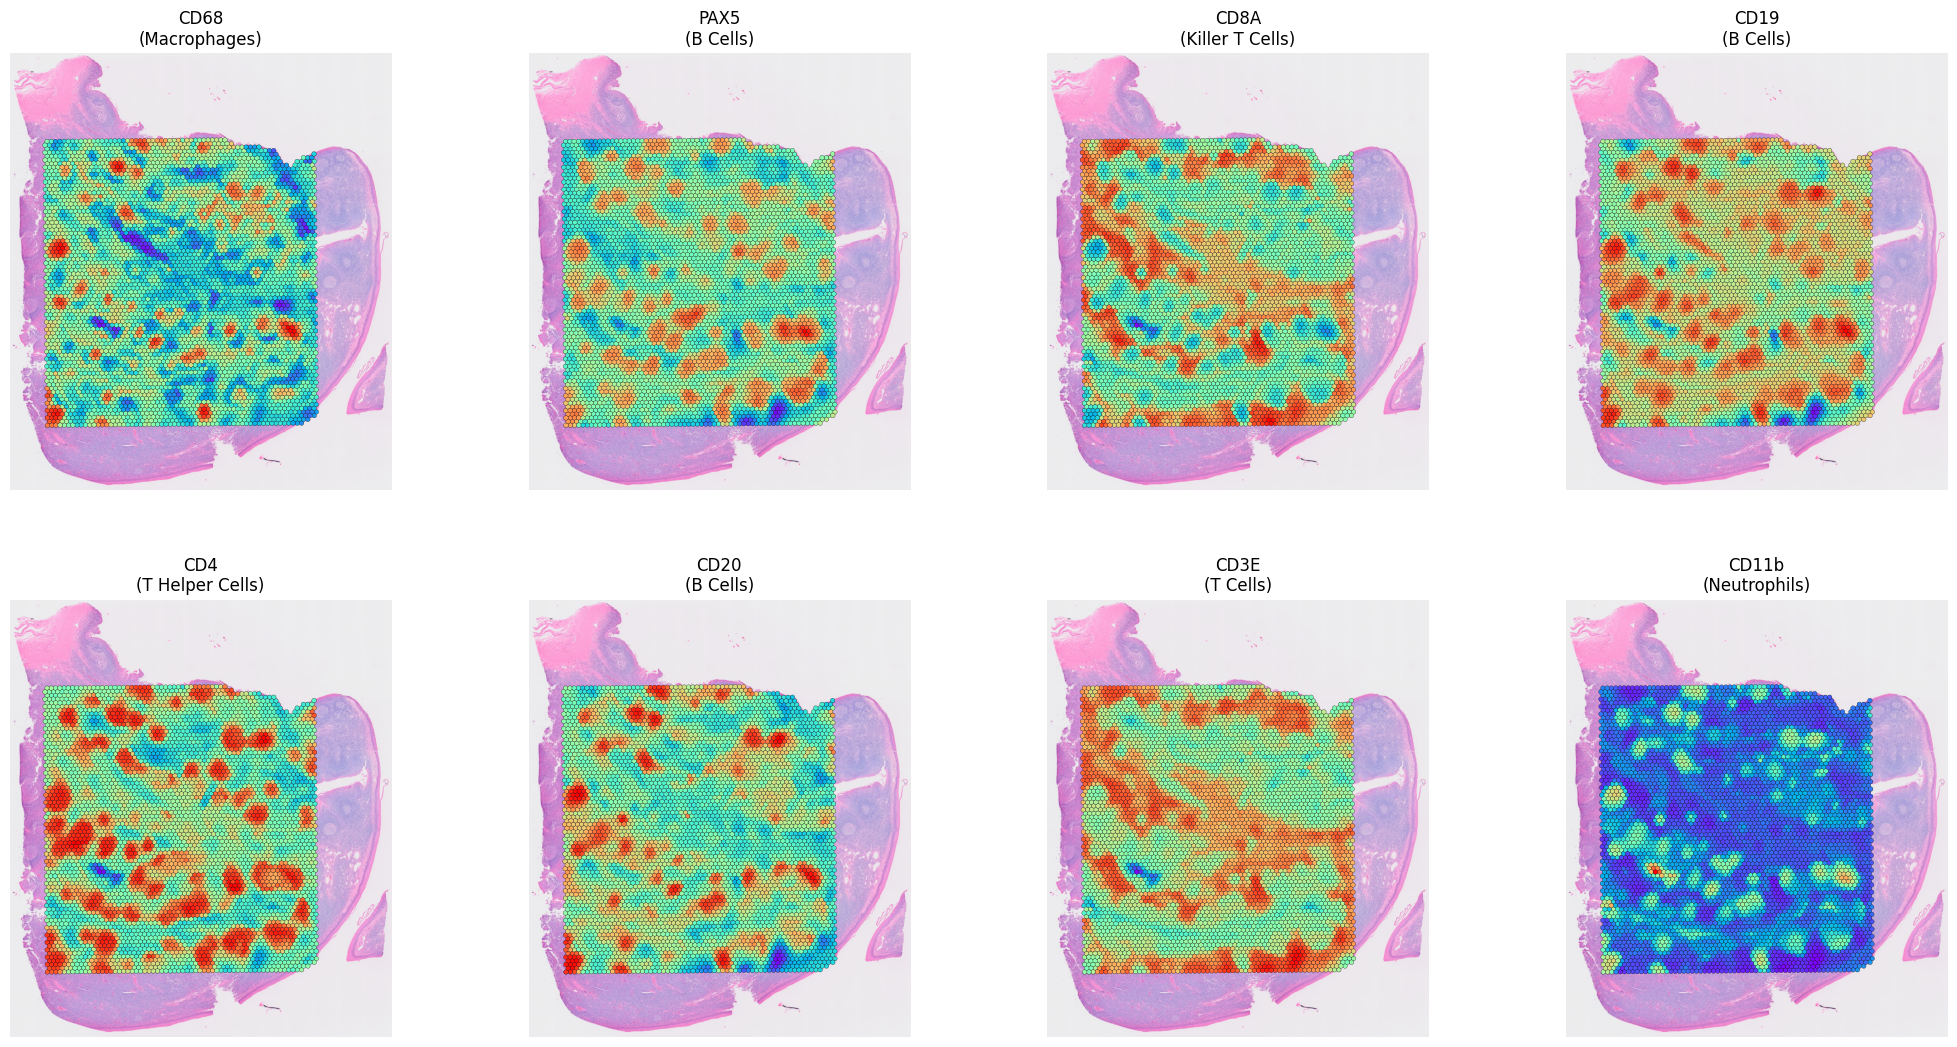

In [86]:
resolution = 0.75
size = 1.55
linewidth = 0.2
img = True
alpha = 0.5


sq.pl.spatial_scatter(pdata_pred, color=['CD68', 'PAX5', 'CD8A', 'CD19', 'CXCR5', 'MS4A1', 'CD3E', 'ITGAM'], size=size, title=['CD68\n(Macrophages)',
 'PAX5\n(B Cells)',
 'CD8A\n(Killer T Cells)',
 'CD19\n(B Cells)',                                                                                                                              
 'CD4\n(T Helper Cells)',
 'CD20\n(B Cells)',
 'CD3E\n(T Cells)',
 'CD11b\n(Neutrophils)'],
                      edgecolor='black', linewidth=linewidth, frameon=False, 
                      alpha=1, img=img, shape='circle', palette=colors, ncols=4, figsize=(6, 6),
                      dpi=100, cmap='rainbow', colorbar=False)

# plt.savefig('./figures/transferred.svg', format='svg', dpi=180)
plt.show()

In [92]:
adata_test = test_loader.run()
gc_pth = 'https://raw.githubusercontent.com/vitkl/cell2location_paper/master/notebooks/selected_results/lymph_nodes_analysis/manual_GC_annot.csv'
df = pd.read_csv(gc_pth).fillna('Other')
df.columns = ['Barcode', 'GroundTruth GC']
adata_test.obs = adata_test.obs.join(df.set_index('Barcode'))

In [93]:
_, adata_test = IntegrateDatasetPipeline('Tonsil', adata, adata_test).run()

Created data integration pipeline.


In [94]:
pdata_pred = infer.run(adata_test)

... storing 'GroundTruth GC' as categorical


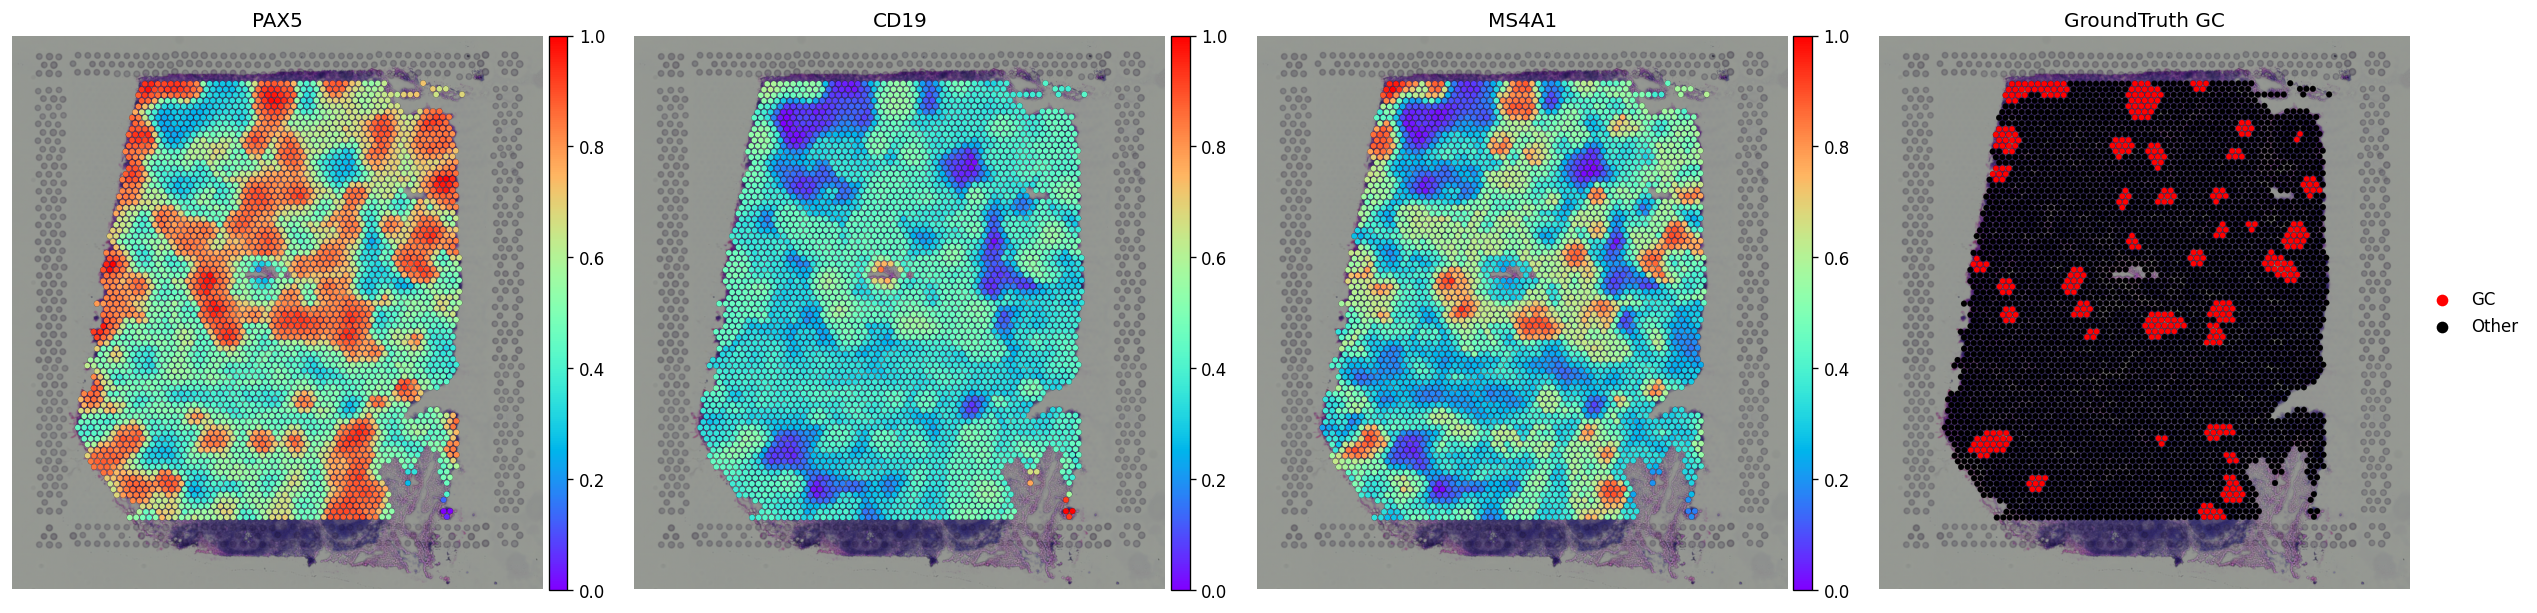

In [16]:
sq.pl.spatial_scatter(pdata_pred, 
    color=['PAX5', 'CD19', 'MS4A1', 'GroundTruth GC'], dpi=120, size=1.4, frameon=False, cmap='rainbow', ncols=4,
    figsize=(6, 6), edgecolor='black', linewidth=0.1, palette=ListedColormap(sns.color_palette(['red', 'black'])))

In [17]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from collections import Counter

def knn_cross_val(X, y, n_neighbors=5, n_splits=10):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    cv_scores = cross_val_score(knn, X, y, cv=n_splits, scoring='roc_auc')
    mean_auc = cv_scores.mean()
    return mean_auc

In [124]:
mrna = adata_test.to_df()[[i.replace('_1', '').replace('_2', '') for i in pdata_pred.var_names]]
spicess_emb = pdata_pred.obsm['embeddings']
proteins = pdata_pred.X
# graphst = pd.read_csv('../graphst_emb.csv', index_col=0).values
# spaceflow = pd.read_csv('./embedding.tsv', header=None, sep='\t').values
y = pdata_pred.obs['GroundTruth GC'].values

In [142]:
pd.DataFrame([knn_cross_val(X, y, n_neighbors=3) for X, label in zip([mrna, proteins, spicess_emb], 
    ['mRNA', 'Proteins', 'Embeddings'])], columns=['AUROC'], index=['mRNA', 'Proteins', 'Embeddings']).T

mRNA  Proteins  Embeddings
AUROC  0.906463  0.921454    0.946554